# Strategy playground

This notebook is designed to be the template where to craft and perform initial exploration of new strategies. What it basically does is:
- Contains the basic code for an EntryStratrgy and ExitStrategy.
- It contains a few examples of signals that could be used and how to combine them.
- It automatically plots the strategies.
- It runs a batch mode of the strategies.

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import Image
%matplotlib qt

import sys
sys.path.insert(0, "..")  # Adds higher directory to python modules path.

from traphing.data_classes import Velas, Portfolio
from traphing import Brain
from traphing.strategies import Trade, Coliseum
from traphing.strategies.entry import EntryStrategy
from traphing.strategies.exit import ExitStrategy
from traphing import BacktestAnalysis

from traphing.utils import Timeframes, unwrap, Actions
import traphing.utils  as ul

from traphing.graph.Gl import gl

folder_images = "./images/python_generated/strategies/"

## Setting up a portfolio

Remember to include the symbols you will be working with!


In [2]:
symbol_names_list = ["AUDCHF", "AUDCAD"]
timeframes_list = [Timeframes.M15, Timeframes.D1]
portfolio_name = "my_portfolio"

storage_folder = "../tests/data/storage/"

portfolio = Portfolio(portfolio_name, symbol_names_list, timeframes_list)
portfolio.load_data_from_csv(storage_folder)

start_time = dt.datetime(2019,6,20); end_time = dt.datetime(2019,7,25)
portfolio.set_time_interval(start_time,end_time)

Size ../tests/data/storage/M15/AUDCHF_M15.csv:  100400  rows
Size ../tests/data/storage/D1/AUDCHF_D1.csv:  4894  rows
Size ../tests/data/storage/M15/AUDCAD_M15.csv:  99483  rows
Size ../tests/data/storage/D1/AUDCAD_D1.csv:  4963  rows


# Craft your own strategy !

Modify the next strategy as you wish!

## Entry Strategy

In [5]:
class GoldenEntryStrategy(EntryStrategy):
    """ This strategy performs a trade in a given time every day. The trade is BUY if the there has been an increase
    in price from the beggining of the session and SELL otherwise.
    
    
    Example of params:
        indicators = {"time":dt.time(2)}
    """
    def __init__(self, name: str, portfolio: Portfolio = None, params: dict = {}):
        super().__init__(name, portfolio, params)
    
    def compute_input_series(self) -> pd.DataFrame:
        symbol_name = self.symbol_names_list[0]
        timeframe = self.timeframes_list[0]
    
        symbol = self.portfolio[symbol_name]
        velas = self.portfolio[symbol_name][timeframe]
        
        dates_to_trading_session_dict = symbol.market_hours.get_timestamps_by_trading_session_dict(velas.timestamps)
        
        series_df = pd.Series(np.zeros(velas.timestamps.size),index = velas.timestamps, name = "gain")
        
        for date in list(dates_to_trading_session_dict.keys()):
            timestamps_date = dates_to_trading_session_dict[date]
            candlesticks_date = velas.df.loc[timestamps_date] # candlesticks of the date
            
            entry_time = self.params["indicators"]["time"]
            # We substract the timeframe because the timestamp time is the beggining of the candlestick
            timestamp_trigger = candlesticks_date.iloc[0].name + ul.to_timedelta(entry_time) - \
            dt.timedelta(minutes = velas.timeframe.value)
            
            open_trading_session_price = candlesticks_date.iloc[0]["Open"]
            first_hour_trading_session_close_price = candlesticks_date.loc[timestamp_trigger]["Close"]

            gain_first_hour = (first_hour_trading_session_close_price - open_trading_session_price)/first_hour_trading_session_close_price
            
            series_df.loc[timestamp_trigger] = gain_first_hour
            
        series_df = pd.concat([velas.series("Close"), series_df],axis = 1)
        return series_df
    
    def compute_trigger_series(self) -> pd.DataFrame:
        series_df = self.compute_input_series()
        trigger_series = series_df["gain"]
        trigger_series[trigger_series > 0] = 1
        trigger_series[trigger_series < 0] = -1
        pd.DataFrame(trigger_series, columns = [self.symbol_names_list[0]])
        return trigger_series
        
    def compute_requests_queue(self) -> pd.DataFrame:
        trigger_series = self.compute_trigger_series()
        Event_indx = np.where(trigger_series != 0)[0] # We do not care about the second dimension

        for indx in Event_indx:
            action = self._get_action(trigger_series[indx])
            timestamp = trigger_series.index[indx]
            symbol_name = self.symbol_names_list[0]
            timeframe = self.timeframes_list[0]
            price = float(self.portfolio[symbol_name][timeframe].get_candlestick(timestamp)["Close"])
            
            self.create_request(timestamp, symbol_name, timeframe, action, price)
        return self.queue
    

In [6]:
# Initialize
entry_strategy1 = GoldenEntryStrategy("GoldenEntryStrategy", portfolio)
# Set the paramters
symbol_name = symbol_names_list[0]
timeframe = timeframes_list[0]

portfolio_params = {"symbol_names_list":[symbol_name], "timeframes_list":[timeframe]}
indicators_params = {"time":dt.time(2)}
exit_strategy_params = {"class_name":"ExitTime",
                        "params":{"indicators":{"time":dt.time(15)}}}
params = {"portfolio": portfolio_params, "indicators": indicators_params, "exit_strategy":exit_strategy_params}
entry_strategy1.set_params(params)

In [28]:
# Initialize
entry_strategy2 = GoldenEntryStrategy("GoldenEntryStrategy2", portfolio)
# Set the paramters
symbol_name = symbol_names_list[1]
timeframe = timeframes_list[0]

portfolio_params = {"symbol_names_list":[symbol_name], "timeframes_list":[timeframe]}
indicators_params = {"time":dt.time(2)}
exit_strategy_params = {"class_name":"ExitTime",
                        "params":{"indicators":{"time":dt.time(10)}}}
params = {"portfolio": portfolio_params, "indicators": indicators_params, "exit_strategy":exit_strategy_params}
entry_strategy2.set_params(params)

## Strategies visualization

In [29]:
entry_strategy_input = entry_strategy1.compute_input_series()
entry_strategy_triggers = entry_strategy1.compute_trigger_series()
entry_requests_queue = entry_strategy1.compute_requests_queue()

n_requests = entry_requests_queue.qsize()
entry_requests_dict = dict([entry_requests_queue.get() for i in range(n_requests)])
entries_dates = sorted(list(entry_requests_dict.keys()))
entry_request = entry_requests_dict[entries_dates[0]]

In [30]:
trade = Trade(name = "my_trade12", request = entry_request, price = entry_request.price)
exit_strategy = entry_strategy1.create_exit_strategy(trade)

exit_strategy_input = exit_strategy.compute_input_series()
exit_strategy_triggers = exit_strategy.compute_trigger_series()
exit_requests_queue = exit_strategy.compute_requests_queue()
n_requests = exit_requests_queue.qsize()
exit_requests_dict = dict([exit_requests_queue.get() for i in range(n_requests)])
exits_dates = sorted(list(exit_requests_dict.keys()))
#exit_request = exit_requests_dict[exits_dates[0]]

In [31]:
pd.concat([entry_strategy_input, entry_strategy_triggers, exit_strategy_input, exit_strategy_triggers], axis = 1)

,Close,gain,gain,trigger_time,trigger_time_2
Timestamp,,,,,
2019-06-20 00:00:00,0.68379,0.0,0.0,0.0,0.0
2019-06-20 00:15:00,0.68355,0.0,0.0,0.0,0.0
2019-06-20 00:30:00,0.68343,0.0,0.0,0.0,0.0
2019-06-20 00:45:00,0.68352,0.0,0.0,0.0,0.0
2019-06-20 01:00:00,0.68367,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2019-07-25 22:45:00,0.68865,0.0,0.0,0.0,0.0
2019-07-25 23:00:00,0.68866,0.0,0.0,0.0,0.0
2019-07-25 23:15:00,0.68887,0.0,0.0,0.0,0.0


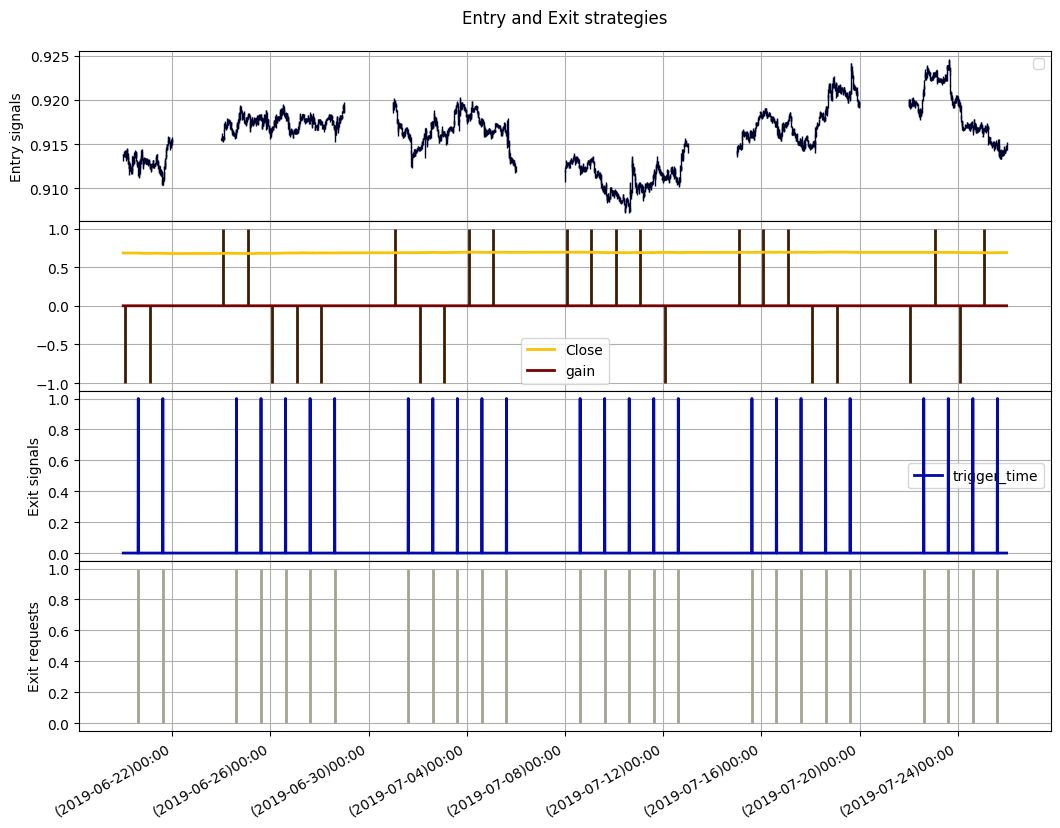

In [32]:
image_name = "entry_and_exit.png"; img_path = folder_images + image_name
gl.init_figure()
n_rows, n_cols = 4,1; size_inches = [12, 8]
ax1 = gl.subplot2grid((n_rows, n_cols),(0,0))
ax2 = gl.subplot2grid((n_rows, n_cols),(1,0), sharex = ax1)
ax3 = gl.subplot2grid((n_rows, n_cols),(2,0), sharex = ax1)
ax4 = gl.subplot2grid((n_rows, n_cols),(3,0), sharex = ax1)

## Plot entry #####################
portfolio[symbol_name][timeframe].plot_barchart(axes = ax1, labels = ["Entry and Exit strategies", "", "Entry signals"])

gl.plot(entry_strategy_input.index, entry_strategy_input, legend = list(entry_strategy_input.columns), axes =ax2)
gl.stem(entry_strategy_triggers.index,entry_strategy_triggers, axes = ax2, legend = "Trades")

## Plot exit #############################
gl.plot(exit_strategy_input.index, exit_strategy_input, axes = ax3, 
        legend = list(exit_strategy_input.columns), labels = ["", "", "Exit signals"])

gl.stem(exit_strategy_triggers.index,exit_strategy_triggers, axes = ax4, legend = "Exits", labels = ["", "", "Exit requests"])

gl.subplots_adjust(left=.09, bottom=.10, right=.90, top=.95, wspace=.20, hspace=0, hide_xaxis = True)

gl.save_figure(img_path, dpi = 100, size_inches = size_inches, close = True)
Image(img_path)

# Backtesting time

The Coliseum Class contains all the Entry and Exit strategies.

In [33]:
coliseum = Coliseum()
coliseum.add_entry_strategy(entry_strategy1)
coliseum.add_entry_strategy(entry_strategy2)

brain = Brain(coliseum, portfolio)
backtest_analysis = BacktestAnalysis(brain)
trade_analysis_df = backtest_analysis.backtest()

----- Performing Backtesting ---------
Period: 2019-06-20 - 2019-07-25
Total number of entry trade requests:  52

Req: 104: Exit_for_trade_GoldenEntryStrategy#155#0. Time: 2019-07-25 pct time: 98.93%                                                                           

## Backtest Analysis


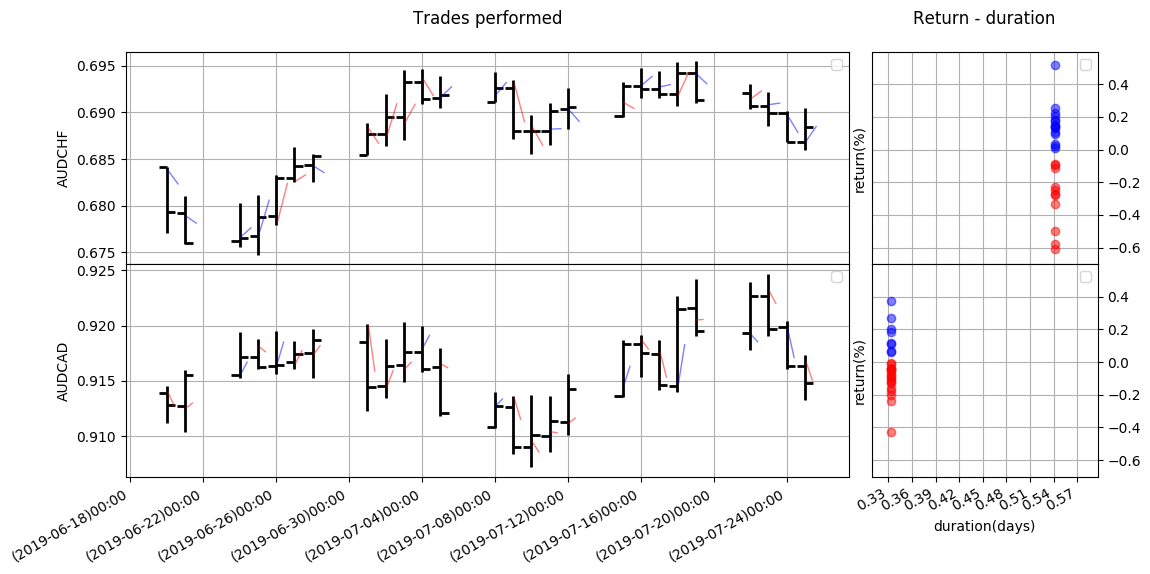

In [34]:
image_name = "backtest_strategies.png"; img_path = folder_images + image_name

symbol_names_list_plot = symbol_names_list
size_inches = [12, 5]
gl.init_figure()
n_rows, n_cols = len(symbol_names_list_plot),4

axes_list = [[],[]]
ax1, ax2 = None, None

for i in range (n_rows):
    ax1 = gl.subplot2grid((n_rows, n_cols),(i,0), sharex = ax1, colspan = n_cols-1)
    ax2 = gl.subplot2grid((n_rows, n_cols),(i,n_cols-1), sharex = ax2, sharey = ax2)
    ax2.yaxis.tick_right()
    
    symbol_name = symbol_names_list_plot[i]
    velas = portfolio[symbol_name][Timeframes.D1]
    
    velas.plot_barchart(axes = ax1, labels = ["Trades performed","",symbol_name], color = "k", lw = 2)
    backtest_analysis.plot_trades(ax1, symbol_name)
    
    backtest_analysis.plot_return_duration_scatter(ax2, symbol_name)
    axes_list[0].append(ax1); axes_list[1].append(ax2)

gl.subplots_adjust(left=.09, bottom=.10, right=.90, top=.95, wspace=.10, hspace=0, hide_xaxis = True, axes_by_columns = axes_list)
gl.save_figure(img_path, dpi = 100, size_inches = size_inches, close = True)
Image(img_path)